In [1]:
!pip install matplotlib numpy pandas SciencePlots


[notice] A new release of pip is available: 24.1.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import json
import os
import sys
import matplotlib.pyplot as plt
from matplotlib import rcParams as rcP
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.rcsetup import cycler
import matplotlib.lines as mlines
import collections
import pandas as pd
from typing import cast, Dict, Callable, Tuple
from format import TimeStampEntity, StepLogEntity, MessageLogEntity, Result, List, Literal, Union
import scienceplots as _
from matplotlib.figure import Figure
from matplotlib.lines import Line2D
from matplotlib.axes import Axes
from matplotlib.collections import PolyCollection
from matplotlib.legend import Legend
from matplotlib.backends.backend_pdf import PdfPages

# Get the directory of the current file
current_dir = os.getcwd()

In [3]:
# Load data from all the log files
def load_data_from_files(directory):
    dir_list = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    if len(dir_list) == 0:
        # use the directory as the only directory
        dir_list = [directory]
    for d in dir_list:
        dir_path = os.path.join(directory, d)
        log_files = sorted([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        print(f"Loading {len(log_files)} log files from {dir_path}")
        for log_file in log_files:
            log_file_path = os.path.join(dir_path, log_file)
            with open(log_file_path, "r") as file:
                data = json.load(file)
                # print(f"File [{log_file}] loaded: {data['dataHandling']}")
                yield data

def get_full_log_key(log:Result, additional_params:Dict[str, Union[str, int, float]] = {}):
    basic_key = f"{log['numberOfSimulatedEvents']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_{log['targetFrames']}_{log['browser']}"
    for _, value in additional_params.items():
        basic_key += f"_{value}"
    return basic_key

def serialize_data(dir_path:str, additional_params:Dict[str, Union[str, int, float]] = {}):
    # SET THE PATH TO THE LOG FILE DIRECTORY
    log_dir = os.path.join(current_dir, dir_path )
    data = {}
    for log in load_data_from_files(log_dir):
        log['numberOfSimulatedEvents'] = int(log['numberOfSimulatedEvents'])
        log['numberOfBins'] = int(log['numberOfBins'])
        log['targetFrames'] = float(log['targetFrames'])
        result_log = cast(Result, log)
        result_log.update(additional_params)
        # create a new key for the data
        log_key = get_full_log_key(result_log, additional_params)
        if(log_key not in data):
            data[log_key] = [result_log]
        else:
            data[log_key].append(result_log)
    
    return data

In [4]:
all_electrons_serialized_data: Dict[str, Result] = {} #serialize_data("logs\\allElectronsScenario\\", {"operatingSystem": "Windows"})

In [5]:
all_protons_serialized_data: Dict[str, Result] = {} #serialize_data("logs\\allProtonsScenario\\", {"operatingSystem": "Windows"})

In [6]:
basic_serialized_data: Dict[str, Result] = serialize_data("logs\\basicScenario\\", {"operatingSystem": "Windows"})

Loading 8714 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\basicScenario\


In [7]:
linux_basic_serialized_data: Dict[str, Result] = serialize_data("logs\\leszekData\\linux\\", {"operatingSystem": "Linux"})

Loading 160 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\leszekData\linux\logs_firefox_linux_none
Loading 3200 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\leszekData\linux\logs_firefox_linux_x1
Loading 3200 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\leszekData\linux\logs_vivaldi_linux_x1


In [8]:
macos_basic_serialized_data: Dict[str, Result] = serialize_data("logs\\leszekData\\macOS\\", {"operatingSystem": "macOS"})

Loading 3200 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\leszekData\macOS\logs_chrome_macosx_m1
Loading 3200 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\leszekData\macOS\logs_safari_macosx_m1


In [9]:
new_serialized_data: Dict[str, Result] = serialize_data("logs\\newScenario\\logs\\", {"operatingSystem": "Windows"})

Loading 32 log files from d:\Repozytoria\geant4-wasm-performance\result_plot\logs\newScenario\logs\


In [10]:
all_data = [
    all_electrons_serialized_data,
    all_protons_serialized_data,
    basic_serialized_data,
    linux_basic_serialized_data
]

# print out dictionary size
for data in all_data:
    print(f"Dictionary size: {len(data)}")
# print out dictionary keys separated by new lines
for data in all_data:
    continue
    print("\n".join(data.keys()))

Dictionary size: 0
Dictionary size: 0
Dictionary size: 4357
Dictionary size: 3280


In [11]:
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{babel}"
})

In [12]:
def multiple_figues(filename):
    pp = PdfPages(filename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in figs:
        fig.savefig(pp, format='pdf')
    pp.close()

In [13]:
def flatten_data_list(data_list: List[Dict[str,List[Result]]]) -> Dict[str,List[Result]]:
    total_data: Dict[str,List[Result]] = {}
    for data in data_list:
        for key, value in data.items():
            if key not in total_data:
                total_data[key] = value
            elif isinstance(value, (collections.abc.Sequence, np.ndarray)):
                total_data[key] += value
    return total_data

def get_logs_fulfilling_row_criteria(data_list: List[Dict[str,List[Result]]], row_criteria: Dict[str, List[any]]):
    total_data = flatten_data_list(data_list)
    for logs in total_data.values():
        if not all(logs[0][k] in v for k, v in row_criteria.items()):
            continue
        for log in logs:
            yield log

In [14]:
def get_time_df(data_list: List[Dict[str,List[Result]]], row_criteria: Dict[str, List[any]], x_label:str, get_label_fn:Callable[[Result], str]) -> pd.DataFrame:
    rows: List[Dict[str,Union[str,int,float]]] = []
    
    for log in get_logs_fulfilling_row_criteria(data_list, row_criteria):
        simulation_start = [x[1] for x in log["timeStamps"] if x[0] == "simulationStart"]
        simulation_end = [x[1] for x in log["timeStamps"] if x[0] == "simulationEnd"]
        worker_start = [x[1] for x in log["timeStamps"] if x[0] == "workerStart"]
        test_end = [x[1] for x in log["timeStamps"] if x[0] == "testEnd"]
        _, times = zip(*log["timeStamps"])
        get_transformed_time: Callable[[Union[List,None]], Union[float,None]] = lambda x: (x[0] - times[0])/1000.0 if x else None
        rows.append({
            x_label: log[x_label], 
            'test_start': get_transformed_time(times),
            'simulation_start': get_transformed_time(simulation_start),
            'simulation_end': get_transformed_time(simulation_end),  
            'worker_start': get_transformed_time(worker_start),
            'test_end': get_transformed_time(test_end), 
            'label': get_label_fn(log)
        })
    df = pd.DataFrame(rows)
    return df  

In [15]:
def get_split_time_df(data_list: List[Dict[str,List[Result]]], row_criteria: Dict[str, List[any]], get_label_fn:Callable[[Result], str]) -> pd.DataFrame:
    rows: List[Dict[str,Union[str,int,float]]] = []
    
    for log in get_logs_fulfilling_row_criteria(data_list, row_criteria):
        simulation_start = [x[1] for x in log["timeStamps"] if x[0] == "simulationStart"]
        test_end = [x[1] for x in log["timeStamps"] if x[0] == "testEnd"]
        _, times = zip(*log["timeStamps"])
        get_transformed_time: Callable[[Union[List,None],float], Union[float,None]] = lambda x,y=times[0]: (x[0] - y)/1000.0 if x else None
        handle_time = log.get("handleTime", 0)/1000.0
        optimize_time = log.get("optimizeTime", 0)/1000.0
        render_time = log.get("renderTime", 0)/1000.0
        initialize_time = get_transformed_time(simulation_start)
        other_time = get_transformed_time(test_end) - handle_time - optimize_time - render_time - initialize_time
        rows.append({
            'initialize': initialize_time,
            'handle': handle_time,
            'optimize': optimize_time,
            'render': render_time,
            'other': other_time,
            'label': get_label_fn(log)
        })
    df = pd.DataFrame(rows)
    return df  

In [16]:
def plot_time_df(ax: Axes, df: pd.DataFrame, x_label:str, y_label:str) -> Tuple[List[Line2D], List[str]]:
    # sort and group by label and x_label
    grouped = df.sort_values(by=[x_label, 'label']).groupby(['label', x_label])
    # get averages
    grouped_mean = grouped.mean().reset_index()
    grouped_std = grouped.std().reset_index()
    lines:List[Line2D] = []
    labels:List[str] = df['label'].unique()
    for label in labels:
        data = grouped_mean[grouped_mean['label'] == label]
        std = grouped_std[grouped_std['label'] == label]
        series = ax.errorbar(data[x_label], data[y_label], yerr=std[y_label], markersize=2)
        lines.append(series)
    return (lines, labels)

In [17]:
def plot_stackedbar_split_time_df(ax: Axes, df: pd.DataFrame, patch_labels: List[str] = ['initialize', 'handle', 'optimize', 'render', 'other'], bar_gap: float = 1, padding: Tuple[float, float] = (1.5, 1.5), fontsize: int = 8) -> Tuple[List[Line2D], List[str]]:
    # Sort and group by label
    grouped = df.sort_values(by='label').groupby('label')
    # Get averages
    grouped_mean = grouped.mean().reset_index()
    lines: List[Line2D] = []
    labels: List[str] = df['label'].unique()
    
    int_gap = int(bar_gap)
    remainder = bar_gap - int_gap
    
    # Calculate positions for each bar group with gaps
    positions = range(0, len(labels) * (int_gap + 1), int_gap + 1)
    
    # Plot bars with gaps
    for pos, label in zip(positions, labels):
        bottom = 0
        data = grouped_mean[grouped_mean['label'] == label]
        for i, patch_label in enumerate(patch_labels):
            value = data[patch_label].values[0]
            series = ax.bar(pos, value, width=1-(remainder/2), bottom=bottom, label=patch_label)
            # Retrieve the color of the bar and make it darker
            bar_color = series[0].get_facecolor()
            darker_color = mcolors.to_rgba(mcolors.to_hex(bar_color, keep_alpha=True), alpha=1.0)
            darker_color = tuple(c * 0.3 for c in darker_color[:3]) + (darker_color[3],)
            # Annotate the value on top of the bar
            if value > 0:
                ax.text(pos, bottom + value / 2, f'{value:.2f}', ha='center', va='bottom', color=darker_color, fontsize=fontsize, weight='bold')
            bottom += value
            lines.append(series)
    
    # Set x-ticks to the middle of each group of bars
    ax.set_xticks(positions)
    ax.set_xticklabels(labels)
    
    # Add padding to the left and right side of the x-axis
    ax.set_xlim(-padding[0], max(positions) + padding[1])
    
    return (lines, labels)

In [18]:
def fill_between_df(ax: Axes, df: pd.DataFrame, x_label:str, origin_label:str, bound_label:str, pass_cycler_twice: bool=False) -> Tuple[List[PolyCollection], List[str]]:
    # sort and group by label and x_label
    grouped = df.sort_values(by=[x_label, 'label']).groupby(['label', x_label])
    # get averages
    grouped_mean = grouped.mean().reset_index()
    grouped_std = grouped.std().reset_index()
    lines:List[Line2D] = []
    labels:List[str] = df['label'].unique()
    for label in labels:
        data = grouped_mean[grouped_mean['label'] == label]
        # std = grouped_std[grouped_std['label'] == label]
        series = ax.fill_between(data[x_label], data[bound_label], data[origin_label], alpha=0.2)
        if(pass_cycler_twice):
            ax.fill_between([], [])
        lines.append(series)
    return (lines, labels)

In [19]:
def fill_error_df(ax: Axes, df: pd.DataFrame, x_label:str, y_label:str, pass_cycler_twice: bool=False) -> Tuple[List[PolyCollection], List[str]]:
    # sort and group by label and x_label
    grouped = df.sort_values(by=[x_label, 'label']).groupby(['label', x_label])
    # get averages
    grouped_mean = grouped.mean().reset_index()
    grouped_std = grouped.std().reset_index()
    lines:List[Line2D] = []
    labels:List[str] = df['label'].unique()
    for label in labels:
        data = grouped_mean[grouped_mean['label'] == label]
        std = grouped_std[grouped_std['label'] == label]
        series = ax.fill_between(data[x_label], data[y_label] - std[y_label], data[y_label] + std[y_label], alpha=0.2)
        if(pass_cycler_twice):
            ax.fill_between([], [])
        lines.append(series)
    return (lines, labels)

In [20]:
def plot_simulation_time_df(ax: Axes, df: pd.DataFrame, x_label:str) -> Tuple[List[Line2D], List[str]]:
    # 'test_start'
    # 'worker_start'
    # 'simulation_start'
    # 'simulation_end'
    # 'test_end'
    start = 'simulation_start'
    end = 'simulation_end'
    lines, labels = plot_time_df(ax, df, x_label, start)
    plot_time_df(ax, df, x_label, end)
    fill_between_df(ax, df, x_label, start, end)
    
    ax.set_xscale('log', base=2)
    # ax.set_yscale('log', base=2)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid()
    # ax.set_xticks(df[x_label])
    return (lines, labels)

In [21]:
def plot_time_with_error_fill_df(ax: Axes, df: pd.DataFrame, x_label:str, y_label:str) -> Tuple[List[Line2D], List[str]]:
    lines, labels = plot_time_df(ax, df, x_label, y_label)
    fill_error_df(ax, df, x_label, y_label)
    ax.set_xscale('log', base=2)
    # ax.set_yscale('log', base=2)
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(plt.ScalarFormatter())
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid()
    ax.set_ylim(bottom=0)
    # ax.set_xticks(df[x_label])
    return (lines, labels)

In [22]:
def annotate_percentage_difference(df: pd.DataFrame, value_label:str, ax: Axes, start: Tuple[float,float], end: Tuple[float,float]):
    # Calculate the mean and std of `value_label` for each group
    group_means = df.groupby('label').mean()[value_label]
    group_stds = df.groupby('label').std()[value_label]
    # Sort means and stds by the means
    sorted_means = group_means.sort_values()
    sorted_stds = group_stds.reindex(sorted_means.index)
    # Calculate the percentage difference between the first and last values
    if len(sorted_means) > 1:
        first_value = sorted_means.iloc[0]
        last_value = sorted_means.iloc[-1]
        avg_diff = (last_value - first_value) / first_value * 100  # Convert to percentage
        std_diff = np.sqrt(sorted_stds.iloc[0]**2 + sorted_stds.iloc[-1]**2)
        ax.annotate(f'Różnica: ${avg_diff:.2f}\\% \\pm{std_diff:.2f}\\%$', start, end, arrowprops=dict(arrowstyle='->'))
    else:
        print("Not enough data to calculate percentage difference.")

In [23]:
def set_prop_cycle(nseries:int=6, ax:Axes=None):
    colors = ["0d49fb", "e6091c", "26eb47", "8936df", "fec32d", "25d7fd", "ff7f0e", "2ca02c", "d62728", "9467bd", "8c564b", "e377c2", "7f7f7f", "bcbd22", "17becf"]
    linestyles = ['--', ':', '-.', '--', ':', '-.', '--', ':', '-.', '--', ':', '-.', '--', ':', '-.']
    markers = ['o', 's', 'x', 'o', 's', 'x', 'o', 's', 'x', 'o', 's', 'x', 'o', 's', 'x']
    colors = colors[:nseries] + colors[:nseries]
    linestyles = linestyles[:nseries] + ['-' for i in range(nseries)]
    markers = markers[:nseries] + markers[:nseries]
    if ax is not None:
        ax.set_prop_cycle(cycler('color', colors) + cycler('ls', linestyles) + cycler('marker', markers))
    else:
        rcP['axes.prop_cycle'] = (
            cycler('color', colors) 
            + cycler('ls', linestyles)
            + cycler('marker', markers)
        )

In [24]:
def setup_plt(nrows:int =1, ncols:int=1, width:float = 1., height:float =1.,dpi: int = 200) -> tuple[Figure, List[Axes]]:
    plt.close('all')
    set_prop_cycle()
    fig, ax = plt.subplots(ncols, nrows)
    size = fig.get_size_inches()
    fig.set_size_inches(size[0]*nrows*width, size[1]*ncols*height)
    fig.dpi = dpi
    fig.tight_layout()
    # flatten axes if there are multiple rows or columns
    ax = ax.flatten() if isinstance(ax, np.ndarray) else [ax]
    return (fig, ax)

In [25]:
def setup_legend(ax: Axes, lines: List[Line2D], labels: List[str], title: str = 'Legenda') -> Legend:
    legend = ax.legend(lines, labels, title=title, frameon=True)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(.7)
    legend.get_frame().set_linewidth(0)
    return legend

In [26]:
def init_and_sim_time_comparation_across_diff_web_envs(data_array:List[Dict[str, Result]], filename:str='', expected_nseries:int=3):
    with plt.style.context(['science', 'ieee']):
        fig, ax_list = setup_plt(2,1,0.7)
        x_labels = ['numberOfSimulatedEvents', 'numberOfSimulatedEvents']
        y_labels = ['simulation_end', 'simulation_start']
        criteria_list = [
            dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
            dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
        ]
        label_fn_list = [
            lambda log: log['browser'].split('_')[0] + '_' + log['operatingSystem'],
            lambda log: log['browser'].split('_')[0] + '_' + log['operatingSystem'],
        ]
        for i in range(2):
            ax = ax_list[i]
            set_prop_cycle(expected_nseries, ax)
            x_label = x_labels[i]
            y_label = y_labels[i]
            row_criteria = criteria_list[i]
            get_label_fn = label_fn_list[i]
            df = get_time_df(
                data_array, 
                row_criteria,
                x_label, get_label_fn
            )
            # normalize 'simulation_end' by 'simulation_start'
            if(y_label == 'simulation_end'):
                df['simulation_end'] = df['simulation_end'] - df['simulation_start']
            lines, labels = plot_time_with_error_fill_df(ax, df, x_label, y_label)
            ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
            if(y_label == 'simulation_end'):
                ax.set_ylabel('Czas trwania samej symulacji (s)')
            else:
                ax.set_ylabel('Czas inicjalizacji symulatora (s)')
            # add legend and map labels into human readable form
            if(i==0):
                legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Środowisko')
            if(y_label == 'simulation_end'):
                print('A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.')
            else:
                print('B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.')
        if filename != '':
            multiple_figues(filename)
        plt.show()

In [27]:
def init_and_sim_time_comparation_across_diff_configs(data_array:List[Dict[str, Result]], filename:str='', expected_nseries:int=2):
    with plt.style.context(['science', 'ieee']):
        fig, ax_list = setup_plt(2,1,0.7)
        x_labels = ['numberOfSimulatedEvents', 'numberOfSimulatedEvents']
        y_labels = ['simulation_end', 'simulation_start']
        criteria_list = [
            dict(dataHandling=["all_raw", 'none'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8','Safari']), #Firefox_5 Vivaldi_6.8
            dict(dataHandling=["all_raw", 'none'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8','Safari']),
        ]
        label_fn_list = [
            lambda log: dict(
                all_raw='RV',
                all_optimized='OV',
                none='NV'
            )[log['dataHandling']] + ' ' + log['operatingSystem'][0],
            lambda log: dict(
                all_raw='RV',
                all_optimized='OV',
                none='NV'
            )[log['dataHandling']] + ' ' + log['operatingSystem'][0],
        ]
        for i in range(2):
            ax = ax_list[i]
            set_prop_cycle(expected_nseries, ax)
            x_label = x_labels[i]
            y_label = y_labels[i]
            row_criteria = criteria_list[i]
            get_label_fn = label_fn_list[i]
            df = get_time_df(
                data_array, 
                row_criteria,
                x_label, get_label_fn
            )
            # normalize 'simulation_end' by 'simulation_start'
            if(y_label == 'simulation_end'):
                df['simulation_end'] = df['simulation_end'] - df['simulation_start']
            lines, labels = plot_time_with_error_fill_df(ax, df, x_label, y_label)
            ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
            if(y_label == 'simulation_end'):
                ax.set_ylabel('Czas trwania samej symulacji (s)')
            else:
                ax.set_ylabel('Czas inicjalizacji symulatora (s)')
            # add legend and map labels into human readable form
            legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Konfiguracja')
            if(y_label == 'simulation_end'):
                print('A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.')
            else:
                print('B) Porównanie czasu inicjalizacji symulatora z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.')
        if filename != '':
            multiple_figues(filename)
        plt.show()

In [60]:
def visualization_parts_compared_stacked_bars(data_array:List[Dict[str, Result]],filename:str=''):
    with plt.style.context(['science', 'ieee']):
        fig, ax_list = setup_plt()
        criteria_list = [
            dict(numberOfSimulatedEvents=[512],dataHandling=["all_raw", 'all_optimized'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Firefox_5']), #Vivaldi_6.8
        ]
        patch_label_list = [
            [['initialize','handle','optimize','render','other'],
             ['Inicializacja', 'Obsługa', 'Optymalizacja', 'Renderowanie', 'Inne']],
        ]
        label_fn_list = [
            lambda log: dict(
                all_raw='RV',
                all_optimized='OV',
                none='NV'
            )[log['dataHandling']] + ' ' + log['operatingSystem'][0],
        ]
        for i in range(1):
            ax = ax_list[i]
            row_criteria = criteria_list[i]
            get_label_fn = label_fn_list[i]
            patch_label, localized_patch_label = patch_label_list[i]
            set_prop_cycle(len(patch_label), ax)
            df = get_split_time_df(
                data_array, 
                row_criteria,
                get_label_fn
            )
            lines, labels = plot_stackedbar_split_time_df(ax, df, patch_label, 0.05, (1.75, 1),7)
            ax.set_xlabel('Konfiguracja narzedzia do wizualizacji')
            ax.set_ylabel('Czas trwania wizualizacji (s)')
            # add legend and map labels into human readable form
            legend = setup_legend(ax, lines, localized_patch_label, title='Etap')
            # get df with dataHandling = none and rest the same as row_criteria
            none_row_criteria = dict(**row_criteria)
            none_row_criteria['dataHandling'] = ['none']
            none_df = get_time_df(
                data_array, 
                none_row_criteria,
                'numberOfSimulatedEvents',
                get_label_fn
            )
            #draw horizontal line for test_end from none_df
            if 'test_end' in none_df.columns:
                test_end = none_df['test_end'].mean()
                simulation = ax.axhline(y=test_end, color='r', linestyle='--', linewidth=.75)
                # add text over the line as simulation end
                ax.text(-1, test_end + 0.05, f"Koniec symulacji: {test_end:.2f}", color='r', fontsize=6, weight='bold')
            # if(y_label == 'simulation_end'):
            #     print('A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.')
            # else:
            #     print('B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.')
        #save the figure to pdf
        if filename != '':
            multiple_figues(filename)
        plt.show()

In [29]:
def get_fps_df(data_list: List[Dict[str,List[Result]]], row_criteria: Dict[str, List[any]], get_label_fn:Callable[[Result], str], bucket_size:int=2000) -> Union[pd.DataFrame, str, int]:
    
    rows: List[Dict[str,Union[str,int,float]]] = []
    
    # use with to keep function format consistent. log should be a first yield from get_logs_fulfilling_row_criteria
    valid_logs_generator = get_logs_fulfilling_row_criteria(data_list, row_criteria)
    log = next(valid_logs_generator)
    time_start = log["timeStamps"][2][1]
    # split log['stepLogs'] into buckets based on 'stepEnd' time
    buckets = {}
    step_idx = 0
    message_idx = 0
    while True:
        if step_idx >= len(log['stepLogs']) and message_idx >= len(log['messageLogs']):
            break
            
        [step, message] = [
            log['stepLogs'][step_idx] if step_idx < len(log['stepLogs']) else None,
            log['messageLogs'][message_idx] if message_idx < len(log['messageLogs']) else None
        ]
        if(not step and not message):
            break
        if not message or (step and step['stepEnd'] < message['sendTime']):
            bucket = int((step['stepEnd'] - time_start) / bucket_size)
            if(bucket >= 0 and step['renderStart']):
                if bucket not in buckets:
                    buckets[bucket] = {'frames': 0, 'messages': [0,0], 'data': [[],0],}
                buckets[bucket]['frames'] += 1
                buckets[bucket]['messages'] = [
                    step['remainingMessages'],
                    max(*buckets[bucket]['messages'])
                ]
                buckets[bucket]['data'] = [
                    buckets[bucket]['data'][0][-step['remainingMessages']:],
                    max(sum(buckets[bucket]['data'][0]), buckets[bucket]['data'][1])
                ]
            step_idx += 1
        else:
            bucket = int((message['sendTime'] - time_start) / bucket_size)
            if(bucket >= 0):
                if bucket not in buckets:
                    buckets[bucket] = {'frames': 0, 'messages': [0,0], 'data': [[],0],}
                buckets[bucket]['messages'][0] += 1
                buckets[bucket]['data'][0].append(message['packageSize'])
            message_idx += 1
    # update buckets
    # enumerate over buckets and sum the data
    for bucket in buckets:
        buckets[bucket]['data'] = max(sum(buckets[bucket]['data'][0]), buckets[bucket]['data'][1])
        buckets[bucket]['messages'] = max(*buckets[bucket]['messages'])
    
    df = pd.DataFrame(buckets)
    # add label to the dataframe
    return (df, get_label_fn(log), bucket_size)

In [30]:
def plot_horizon_average_frames_df(num_bands:int, bucket_size: int, band_height: float, ax: Axes, frames: pd.DataFrame, colors:List[str]) -> Tuple[List[Line2D], List[str]]:
    # Plot each band
    for i in range(num_bands):
        # draw histogram bars for each band starting from the 0 and ending at the band height or current value if it is smaller than band height * (i + 1)
        heights = [min(max(0, val - band_height * i),band_height)*1000.0/bucket_size for val in frames]
        ax.bar(frames.index*bucket_size/1000.0, heights, bottom=0, color=colors[i], label=f"Band {i}", width=bucket_size/1000.0, align='edge')
        # remove tick labels

    # Set labels and title

In [31]:
def plot_horizon_max_data_size_df(num_bands:int, bucket_size: int, band_height: float, ax: Axes, frames: pd.DataFrame, colors:List[str]) -> Tuple[List[Line2D], List[str]]:
    # Plot each band
    for i in range(num_bands):
        # draw histogram bars for each band starting from the 0 and ending at the band height or current value if it is smaller than band height * (i + 1)
        heights = [min(max(0, val - band_height * i),band_height)/(1024.0 * 1024) for val in frames]
        ax.bar(frames.index*bucket_size/1000.0, heights, bottom=0, color=colors[i], label=f"Band {i}", width=bucket_size/1000.0, align='edge')
        # remove tick labels

    # Set labels and title

In [32]:
def plot_all_horizon_average_frames_df(
    ax_list: List[Axes],
    criteria_list: List[Dict[str, List[any]]],
    label_fn: Callable[[Result], str],
    data_array:List[Dict[str, Result]],
    bucket_size: int = 2000
):
    frame_list = []
    labels = []
    for i in range(len(ax_list)):
        row_criteria = criteria_list[i]
        df, label, _ = get_fps_df(
            data_array,
            row_criteria,
            label_fn,
            bucket_size
        )
        frame_list.append(df.loc['frames'].astype(int))
        labels.append(label)
    # get the maximum value from all the dataframes
    max_val = max([frames.max() for frames in frame_list])
    num_bands = 6
    band_height = round(max_val / num_bands)
    print(f"Max value: {max_val}, band height: {band_height}, num bands: {num_bands}")
    colors = plt.cm.viridis(np.linspace(0, 1, num_bands))
    
    for i in range(len(ax_list)):
        plot_horizon_average_frames_df(num_bands, bucket_size, band_height, ax_list[i], frame_list[i], colors)
        ax_list[i].set_ylabel(labels[i])
    max_x = (max([max(frames.index) for frames in frame_list])+1)*bucket_size/1000.0
    # unifiy y axis range
    for ax in ax_list:
        ax.set_ylim(0,band_height*1000.0/bucket_size)
        ax.set_xlim(0, max_x)
        ax.set_yticklabels([])
    for ax in ax_list[:-1]:
        ax.set_xticklabels([])
    ax_list[-1].set_xlabel('Czas [s]')
    #setup legend    
    ax_list[0].legend([Line2D([0], [0], color=colors[i], lw=4) for i in range(num_bands)],
                      [f"Od {round(10*i*band_height*1000.0/bucket_size)/10.0} do {round(10*(i+1)*band_height*1000.0/bucket_size)/10.0}" for i in range(num_bands)],
                      title='Zakresy [FPS]',
                      loc='center left', bbox_to_anchor=(1, 0))

In [33]:
def plot_all_horizon_max_package_size_df(
    ax_list: List[Axes],
    criteria_list: List[Dict[str, List[any]]],
    label_fn: Callable[[Result], str],
    data_array:List[Dict[str, Result]],
    bucket_size: int = 2000
):
    data_list = []
    labels = []
    for i in range(len(ax_list)):
        row_criteria = criteria_list[i]
        df, label, _ = get_fps_df(
            data_array,
            row_criteria,
            label_fn,
            bucket_size
        )
        data_list.append(df.loc['data'].astype(int))
        labels.append(label)
    # get the maximum value from all the dataframes
    max_val = max([data_sizes.max() for data_sizes in data_list])
    num_bands = 4
    band_height = round(max_val / num_bands/(1024.0*1024/10))*(1024.0*1024/10)
    print(f"Max value: {max_val}, band height: {band_height}, num bands: {num_bands}")
    colors = plt.cm.plasma(np.linspace(0, 1, num_bands))
    colors 
    
    for i in range(len(ax_list)):
        plot_horizon_max_data_size_df(num_bands, bucket_size, band_height, ax_list[i], data_list[i], colors)
        ax_list[i].set_ylabel(labels[i])
    # get index of last non zero value from data_sizes
    max_x = max([data_sizes[data_sizes > 0].last_valid_index() for data_sizes in data_list if not data_sizes[data_sizes > 0].empty]) * bucket_size / 1000.0
    min_x = min([data_sizes[data_sizes > 0].first_valid_index() for data_sizes in data_list if not data_sizes[data_sizes > 0].empty]) * bucket_size / 1000.0
    # unifiy y axis range
    for ax in ax_list:
        ax.set_ylim(0,band_height/(1024 * 1024))
        ax.set_xlim(min_x, max_x)
        ax.set_yticklabels([])
    for ax in ax_list[:-1]:
        ax.set_xticklabels([])
    ax_list[-1].set_xlabel('Czas [s]')
    #setup legend    
    ax_list[0].legend([Line2D([0], [0], color=colors[i], lw=4) for i in range(num_bands)],
                      [f"Od {round(10*i*band_height/(1024 * 1024))/10.0} do {round(10*(i+1)*band_height/(1024 * 1024))/10.0}" for i in range(num_bands)],
                      title='Zakresy [MB]',
                      loc='center left', bbox_to_anchor=(1, 0))

In [34]:
def visualization_max_package_size_horizon_plot(data_array:List[Dict[str, Result]], criteria_list: List[Dict[str, List[any]]], filename='',bucket_size: int = 2000):
    with plt.style.context(['science', 'ieee']):
        fig, ax_list = setup_plt(1,len(criteria_list),1,0.3)
        fig.subplots_adjust(hspace=0)
        label_fn_list = [
            lambda log: dict(
                new_raw='RN',
                new_optimized='ON',
                all_raw='RV',
                all_optimized='OV',
                none=''
            )[log['dataHandling']] + ' ' + f"{log['targetFrames']}",
        ]
        plot_all_horizon_max_package_size_df(ax_list, criteria_list, label_fn_list[0], data_array, bucket_size)
        if filename != '':
            multiple_figues(filename)
        plt.show()

In [35]:
def visualization_average_frames_horizon_plot(data_array:List[Dict[str, Result]], criteria_list: List[Dict[str, List[any]]], filename='',bucket_size: int = 2000):
    with plt.style.context(['science', 'ieee']):
        fig, ax_list = setup_plt(1,len(criteria_list),1,0.3)
        fig.subplots_adjust(hspace=0)
        label_fn_list = [
            lambda log: dict(
                new_raw='RN',
                new_optimized='ON',
                all_raw='RV',
                all_optimized='OV',
                none=''
            )[log['dataHandling']] + ' ' + f"{log['targetFrames']}",
        ]
        plot_all_horizon_average_frames_df(ax_list, criteria_list, label_fn_list[0], data_array, bucket_size)
        if filename != '':
            multiple_figues(filename)
        plt.show()

Max value: 119, band height: 20, num bands: 6


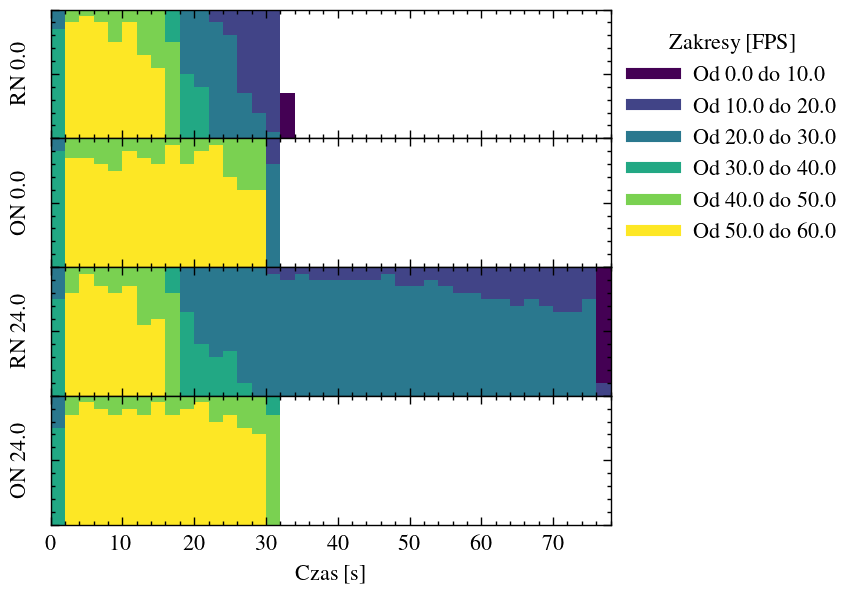

In [36]:
visualization_average_frames_horizon_plot([new_serialized_data],[
            dict(numberOfSimulatedEvents=[32768], dataHandling=["new_raw"], numberOfBins=[32], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.9']), #65 536
            dict(numberOfSimulatedEvents=[32768], dataHandling=["new_optimized"], numberOfBins=[32], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.9']),
            dict(numberOfSimulatedEvents=[32768], dataHandling=["new_raw"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),
            dict(numberOfSimulatedEvents=[32768], dataHandling=["new_optimized"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),
        ], 'horizon_average_frames_electron_new.pdf')

Max value: 1900686, band height: 524288.0, num bands: 4


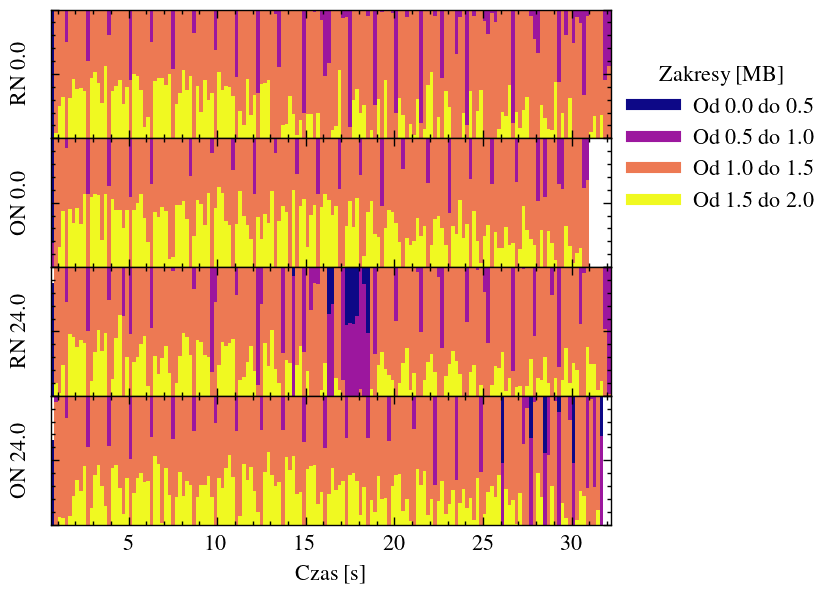

In [37]:
visualization_max_package_size_horizon_plot([new_serialized_data],[
            dict(numberOfSimulatedEvents=[32768], dataHandling=["new_raw"], numberOfBins=[32], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.9']), #65 536
            dict(numberOfSimulatedEvents=[32768], dataHandling=["new_optimized"], numberOfBins=[32], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.9']),
            dict(numberOfSimulatedEvents=[32768], dataHandling=["new_raw"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),
            dict(numberOfSimulatedEvents=[32768], dataHandling=["new_optimized"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),
        ],'horizon_max_package_size_electron_new.pdf',200)

Max value: 79, band height: 13, num bands: 6


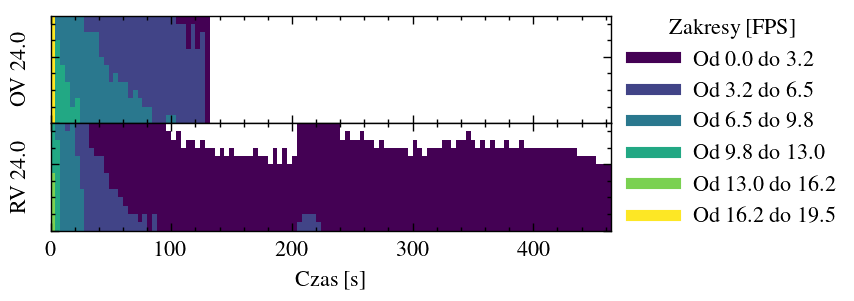

In [83]:
visualization_average_frames_horizon_plot([new_serialized_data],[
            dict(numberOfSimulatedEvents=[2048], dataHandling=["all_optimized"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),
            dict(numberOfSimulatedEvents=[2048], dataHandling=["all_raw"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),],
            'horizon_average_frames_electron_all_framebound.pdf',4000)

Max value: 45, band height: 8, num bands: 6


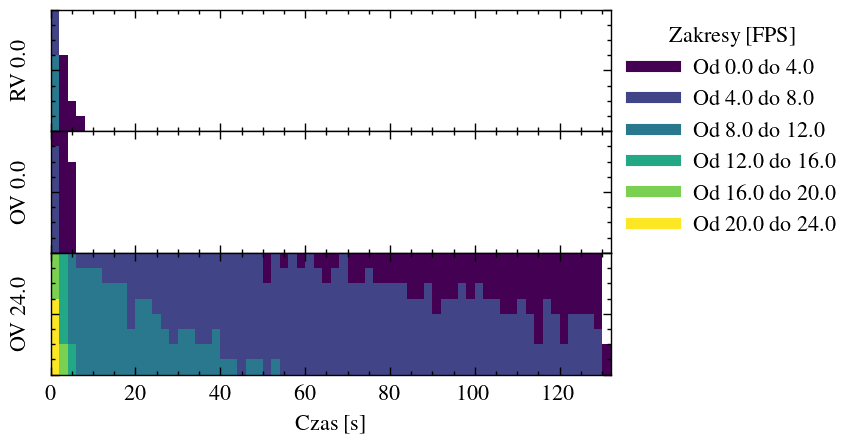

In [84]:
visualization_average_frames_horizon_plot([new_serialized_data],[
            dict(numberOfSimulatedEvents=[4096], dataHandling=["all_raw"], numberOfBins=[32], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.9']), #65 536
            dict(numberOfSimulatedEvents=[4096], dataHandling=["all_optimized"], numberOfBins=[32], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.9']),
            dict(numberOfSimulatedEvents=[2048], dataHandling=["all_optimized"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),],
            'horizon_average_frames_electron_all.pdf',2000)

Max value: 920985, band height: 209715.2, num bands: 4


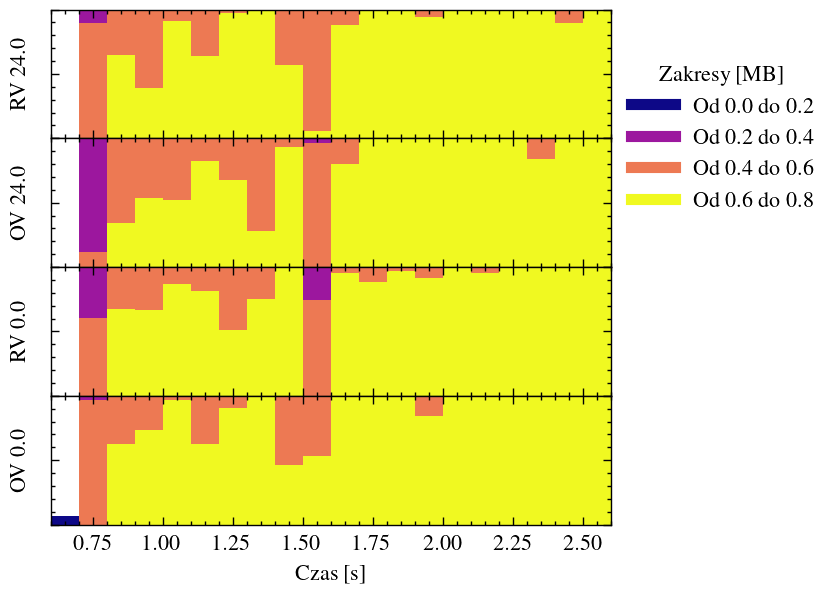

In [40]:
visualization_max_package_size_horizon_plot([new_serialized_data],[
            dict(numberOfSimulatedEvents=[2048], dataHandling=["all_raw"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),
            dict(numberOfSimulatedEvents=[2048], dataHandling=["all_optimized"], numberOfBins=[32], targetFrames=[24], particleType=['electron'], browser=['Vivaldi_6.9']),
            dict(numberOfSimulatedEvents=[2048], dataHandling=["all_raw"], numberOfBins=[32], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.9']), #65 536
            dict(numberOfSimulatedEvents=[2048], dataHandling=["all_optimized"], numberOfBins=[32], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.9']),
        ],'horizon_max_package_size_electron_all_framebound.pdf',100)

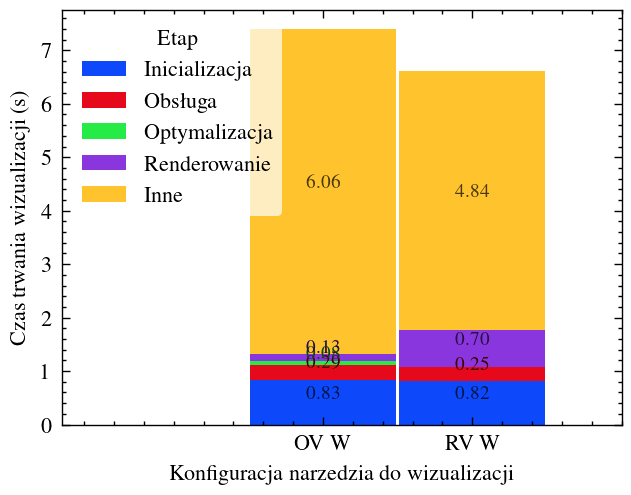

In [41]:
visualization_parts_compared_stacked_bars([basic_serialized_data],'stacked_bars_windows.pdf')

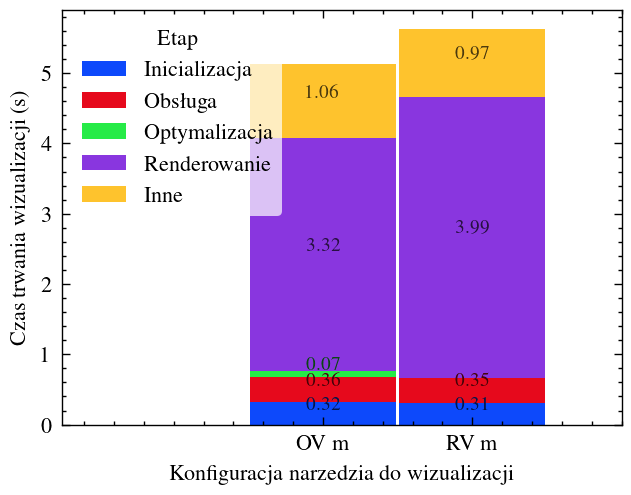

In [42]:
visualization_parts_compared_stacked_bars([macos_basic_serialized_data],'stacked_bars_macos.pdf')

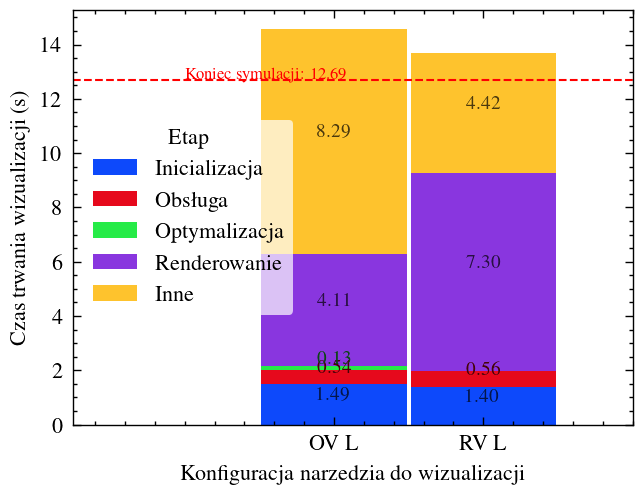

In [61]:
visualization_parts_compared_stacked_bars([linux_basic_serialized_data],'stacked_bars_linux.pdf')

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.
B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.


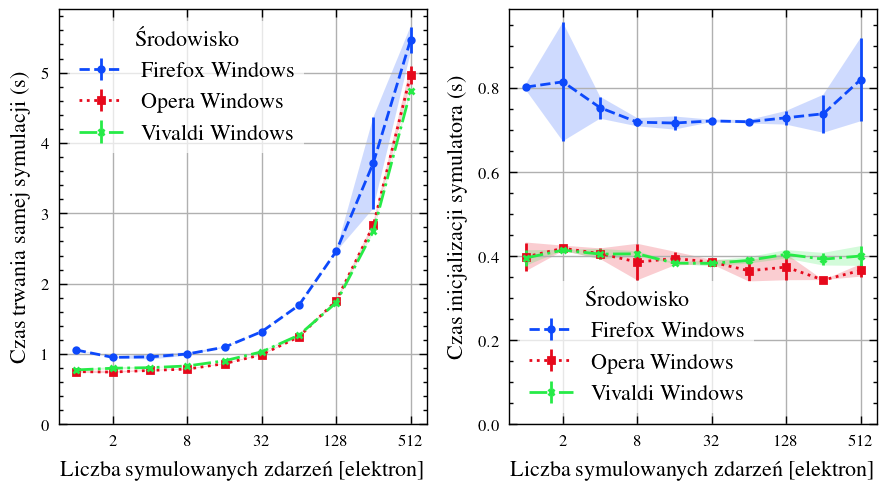

In [44]:
init_and_sim_time_comparation_across_diff_web_envs([basic_serialized_data],'porownanie_czasu_przegladarek_windows.pdf')

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.
B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.


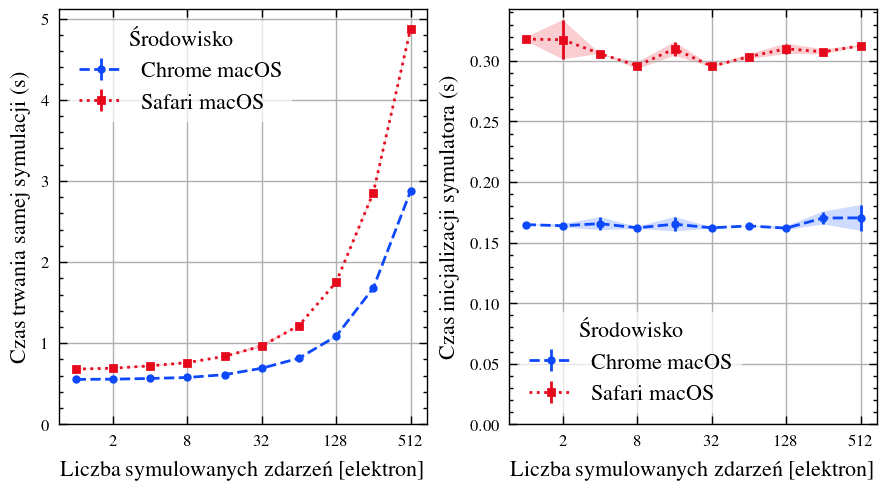

In [45]:
init_and_sim_time_comparation_across_diff_web_envs([macos_basic_serialized_data],'porownanie_czasu_przegladarek_macos.pdf', 2)

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.
B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.


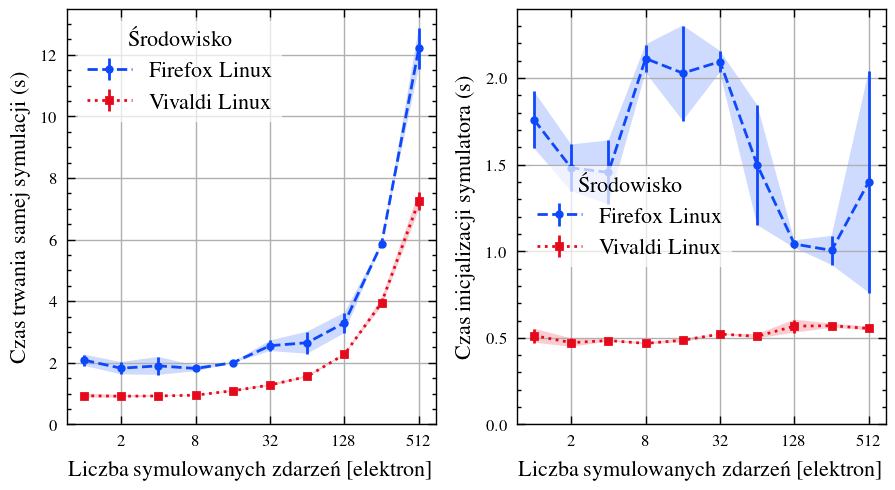

In [46]:
init_and_sim_time_comparation_across_diff_web_envs([linux_basic_serialized_data],'porownanie_czasu_przegladarek_linux.pdf', 2)

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji dla różnych przeglądarek.
B) Porównanie czasu inicjalizacji symulatora dla różnych przeglądarek.


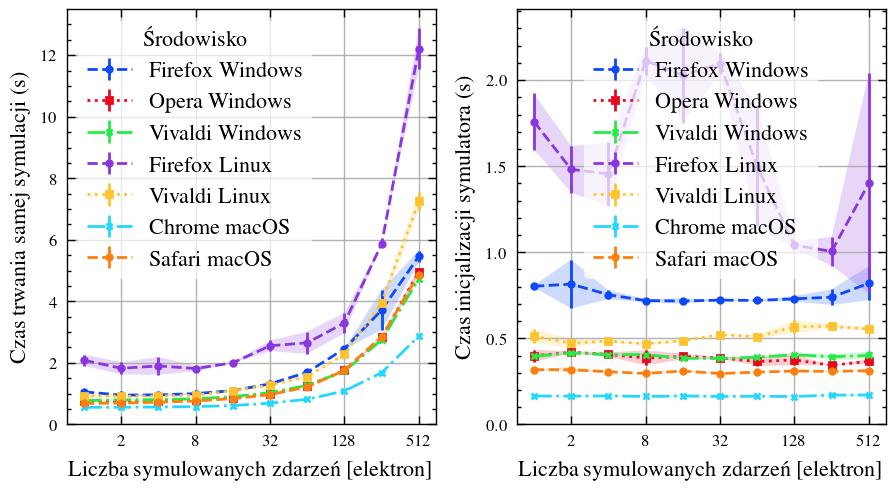

In [47]:
init_and_sim_time_comparation_across_diff_web_envs([basic_serialized_data, linux_basic_serialized_data, macos_basic_serialized_data],'', 7)

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.
B) Porównanie czasu inicjalizacji symulatora z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.


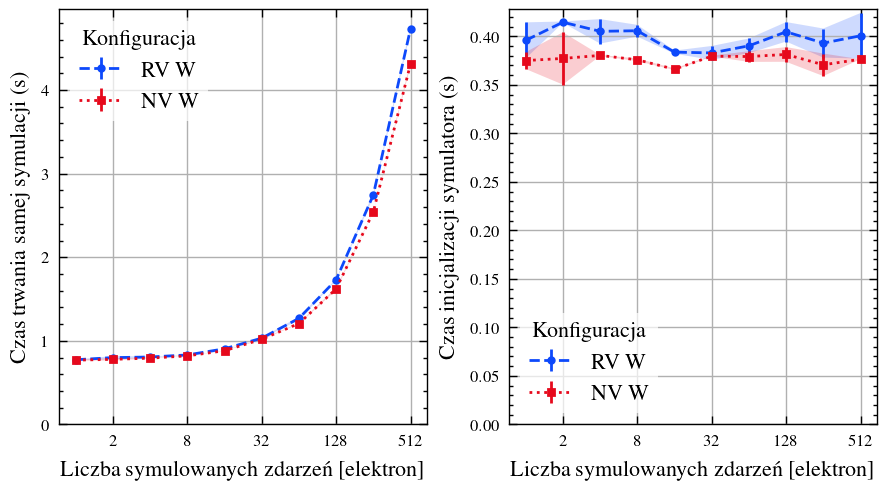

In [48]:
init_and_sim_time_comparation_across_diff_configs([basic_serialized_data],'porownanie_czasu_konfiguracji_windows.pdf', 2)

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.
B) Porównanie czasu inicjalizacji symulatora z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.


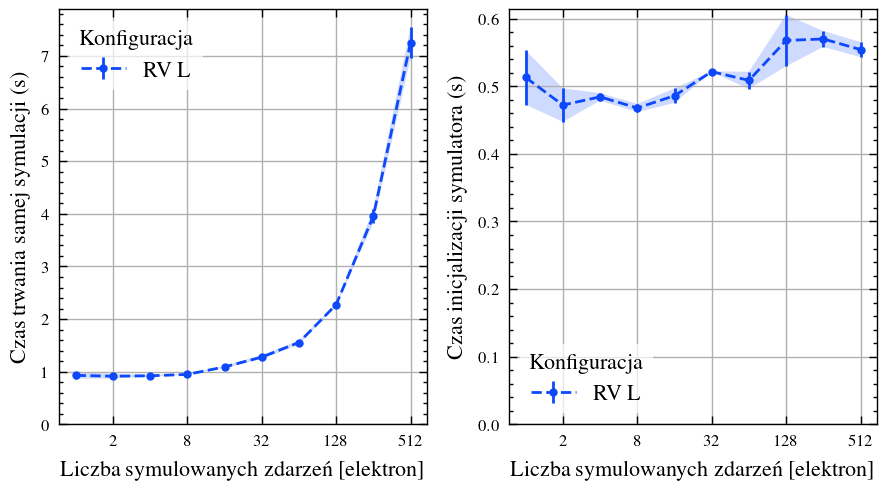

In [49]:
init_and_sim_time_comparation_across_diff_configs([linux_basic_serialized_data],'porownanie_czasu_konfiguracji_linux.pdf', 3)

A) Porównanie czasu trwania samej symulacji niezależnie od inicjalizacji z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.
B) Porównanie czasu inicjalizacji symulatora z uruchomieniem lub bez uruchomienia wizualizacji na równoległym procesie.


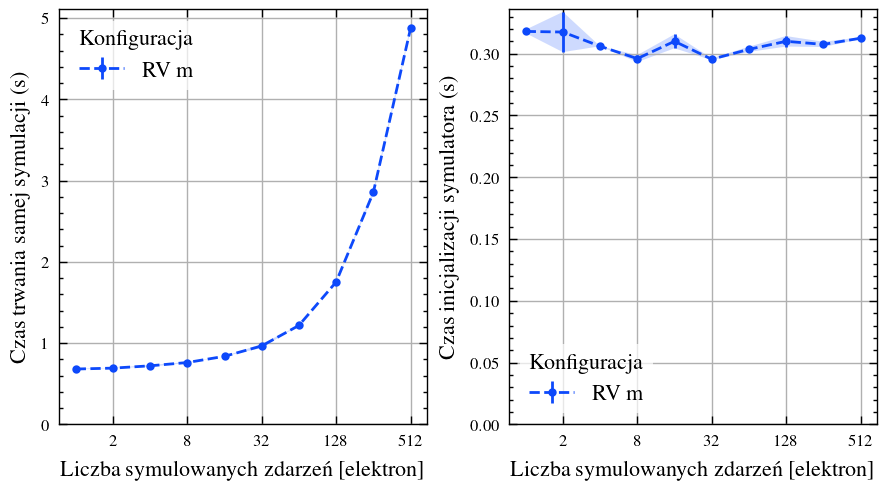

In [50]:
init_and_sim_time_comparation_across_diff_configs([macos_basic_serialized_data],'porownanie_czasu_konfiguracji_macos.pdf', 2)

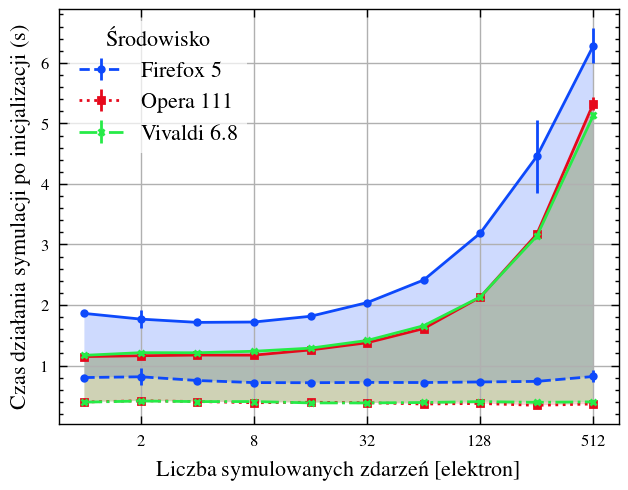

In [51]:
with plt.style.context(['science', 'ieee']):
    fig, [ax] = setup_plt()
    set_prop_cycle(3, ax)
    x_labels = ['numberOfSimulatedEvents', 'numberOfBins']
    row_criteria = [
        dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
        dict(dataHandling=["all_raw"], numberOfSimulatedEvents=[1024], targetFrames=[0], particleType=['electron'])
    ]
    x_label = x_labels[0]
    criteria = row_criteria[0]
    df = get_time_df(
        [all_electrons_serialized_data, basic_serialized_data], 
        criteria,
        x_label, lambda log: log['browser'] # {log['targetFrames']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_
    )
    lines, labels = plot_simulation_time_df(ax, df, x_label)
    ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
    ax.set_ylabel('Czas działania symulacji po inicjalizacji (s)')
    # add legend and map labels into human readable form
    legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Środowisko')
    
    # annotate_percentage_difference(df, 'simulation_start', ax, (6.3, 0.15), (1, 6.5))
    # annotate_percentage_difference(df, 'simulation_end', ax, (68, 2.6), (12,8.25))
    
    plt.show()

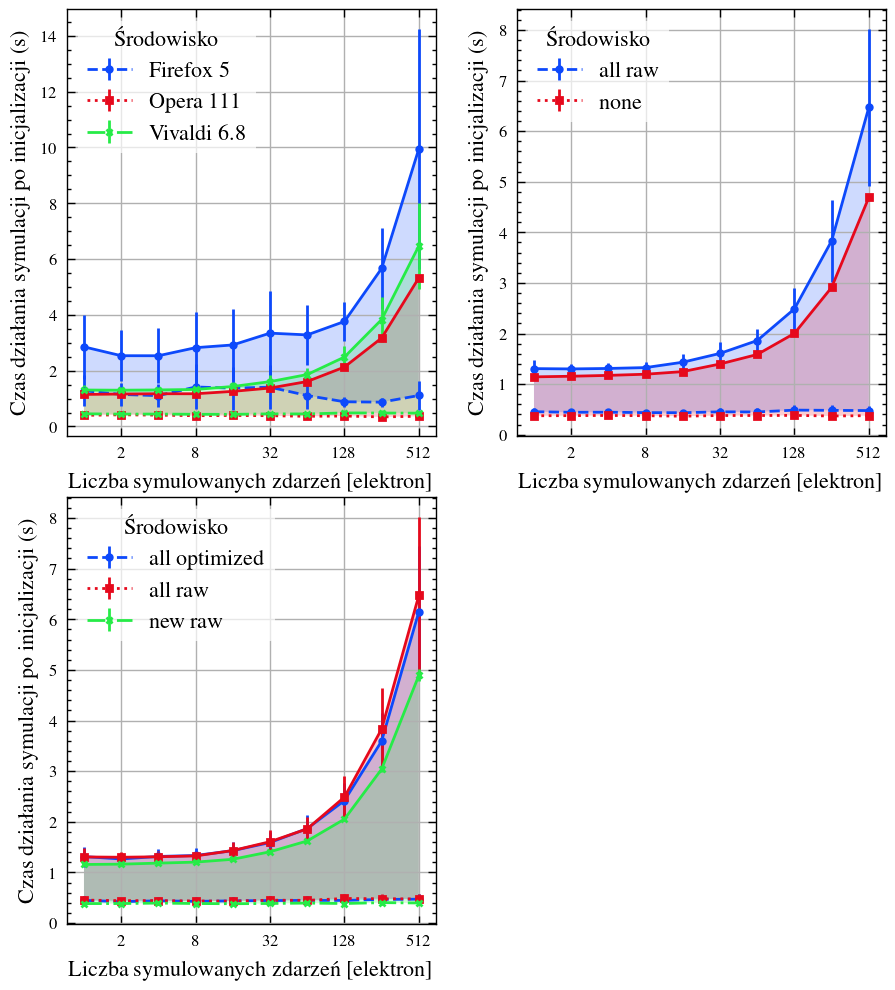

In [52]:
with plt.style.context(['science', 'ieee']):
    fig, axes_list = setup_plt(2,2,0.7)
    x_labels = ['numberOfSimulatedEvents', 'numberOfSimulatedEvents', 'numberOfSimulatedEvents']
    row_criteria = [
        dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
        dict(dataHandling=["all_raw",'none'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8']),
        dict(dataHandling=["all_raw",'new_raw', 'all_optimized'], numberOfBins=[256], targetFrames=[0], particleType=['electron'], browser=['Vivaldi_6.8'])
    ]
    get_label_fns = [
        lambda log: log['browser'],
        lambda log: log['dataHandling'],
        lambda log: log['dataHandling']
    ]
    for i in range(3):
        ax = axes_list[i]
        if i == 1:
            set_prop_cycle(2, ax)
        else:
            set_prop_cycle(3, ax)
        x_label = x_labels[i]
        criteria = row_criteria[i]
        get_label_fn = get_label_fns[i]
        df = get_time_df(
            [basic_serialized_data, linux_basic_serialized_data], 
            criteria,
            x_label, get_label_fn # {log['targetFrames']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_
        )
        lines, labels = plot_simulation_time_df(ax, df, x_label)
        ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
        ax.set_ylabel('Czas działania symulacji po inicjalizacji (s)')
        # add legend and map labels into human readable form
        legend = setup_legend(ax, lines, [label.replace('_', ' ') for label in labels], title='Środowisko')
    
        # annotate_percentage_difference(df, 'simulation_start', ax, (6.3, 0.15), (1, 6.5))
        # annotate_percentage_difference(df, 'simulation_end', ax, (68, 2.6), (12,8.25))
    axes_list[3].remove()
    plt.show()

In [53]:
if False:
    with plt.style.context(['science', 'ieee']):
        plt.close('all')

        human_readable_label = lambda label: label.replace('testEnd', 'All').replace('basic_raw', 'Basic').replace('electron', 'Electron').replace('proton', 'Proton').replace('serial', 'Serial').replace('parallel', 'Parallel').replace('gpu', 'GPU').replace('cpu', 'CPU')
        fig, ax = plt.subplots()
        fig.dpi = 200
        x_label = 'numberOfSimulatedEvents'
        df = get_time_df(
            [all_electrons_serialized_data, basic_serialized_data], 
            dict(dataHandling=["all_raw"], numberOfBins=[256], targetFrames=[0], particleType=['electron']),
            x_label, lambda log: log['browser'] # {log['targetFrames']}_{log['numberOfBins']}_{log['particleType']}_{log['dataHandling']}_
        )
        lines, labels = plot_simulation_time_df(fig, ax, df, x_label)
        ax.set_xlabel('Liczba symulowanych zdarzeń [elektron]')
        ax.set_ylabel('Czas (s)')
        # add legend and map labels into human readable form
        legend = ax.legend(lines, [label.replace('_', ' ') for label in labels], title='Środowisko', frameon=True)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(.7)
        legend.get_frame().set_linewidth(0)
        
        annotate_percentage_difference(df, 'simulation_start', ax, (6.3, 0.15), (1, 6.5))
        annotate_percentage_difference(df, 'simulation_end', ax, (68, 2.6), (12,8.25))
        
        plt.show()
    def plot_total_time(fig: Figure, 
            ax: Axes, 
            data_list: List[Dict[str,List[Result]]], 
            series_criteria: Dict[str, List[any]], 
            x_label, 
            label_fn: Callable[[Result], str]=get_full_log_key,
            sort_labels: Callable[[List[str]], List[str]]=lambda x: sorted(x)
        ) -> List[Tuple[str, Line2D]]:
        # use custom cycler for line styles and don't use '-'
        custom_linestyles=[(0,(4,2)),(0,(1,1)),'-.', (0,(5,2,1,1,1,2)), ]
        rows = []
        lines = []
        # merge all data into one dictionary for easier processing
        # if key is the same, append the data
        total_data: Dict[str,List[Result]] = {}
        [total_data.update(data) for data in data_list]
        for logs in total_data.values():
            if not all(logs[0][k] in v for k, v in series_criteria.items()):
                continue
            label = label_fn(logs[0])
            x = int(logs[0][x_label])
            for log in logs:
                _, times = zip(*log["timeStamps"])
                rows.append({
                    "label": label,
                    "x": x,
                    "y": times[-1] - times[0],
                })
        if len(rows) == 0:
            return []
        df = pd.DataFrame(rows)
        df_mean = df.groupby(["label", "x"]).mean().reset_index()
        df_std = df.groupby(["label", "x"]).std().reset_index()
        
        sorted_labels = sort_labels(df_mean.label.unique())
        
        # Create a categorical type with the order defined by sorted_labels
        df_mean['label'] = pd.Categorical(df_mean['label'], categories=sorted_labels, ordered=True)
        df_std['label'] = pd.Categorical(df_std['label'], categories=sorted_labels, ordered=True)
        
        # Sort the DataFrame based on the 'label' column
        df_mean.sort_values('label', inplace=True)
        df_std.sort_values('label', inplace=True)
        
        # Plotting
        for label, group in df_mean.groupby('label'):
            group = group.sort_values('x')
            [line] = ax.plot(group['x'], group['y'], label=label, linestyle=custom_linestyles[sorted_labels.index(label) % len(custom_linestyles)])
            ax.fill_between(group['x'], group['y'] - df_std.loc[df_std['label'] == label, 'y'].values, group['y'] + df_std.loc[df_std['label'] == label, 'y'].values, alpha=0.2)
            lines.append(line)
        
        return list(zip(sorted_labels, lines))
    def generate_plot_with_total_time(series_criteria, x_label, x_key, y_label, plot_args, 
            label_fn: Callable[[Result], str]=get_full_log_key,
            sort_fn: Callable[[List[str]], List[str]]=lambda x: sorted(x)):
        with plt.style.context(['science', 'ieee', 'high-vis']):
            fig, ax = plt.subplots(figsize=(4, 3))
            fig.dpi = 300
            
            # plot the total time taken for each log
            plots = plot_total_time(fig, ax, plot_args, series_criteria, x_key, label_fn, sort_fn)
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
            print('Tytuł: Porównanie czasów trwania symulacji oraz wizualizacji dla różnych środowisk przeglądarkowych')
            ax.set_xscale("log", base=2)
            ax.set_yscale("log", base=2)
            ax.grid()
            labels, lines = zip(*plots)
            legend = ax.legend([(mpatches.Patch(color=line.get_color(), linewidth=0, alpha=0.2), line) for line in lines], labels, frameon=True)
            legend.get_frame().set_facecolor('white')
            legend.get_frame().set_alpha(.5)
            legend.get_frame().set_linewidth(0)
            plt.show()

    def generate_two_plots_with_total_time(series_criteria_a, series_criteria_b, x_label_a, x_label_b, x_key, y_label, plot_args_a, plot_args_b, 
            label_fn: Callable[[Result], str]=get_full_log_key, 
            sort_fn: Callable[[List[str]], List[str]]=lambda x: sorted(x)):
        with plt.style.context(['science', 'ieee', 'high-vis']):
            fig, axs = plt.subplots(1, 2, figsize=(8, 3))
            fig.dpi = 200
            for i, (ax, plot_args, series_criteria, x_label) in enumerate(zip(axs, [plot_args_a, plot_args_b], [series_criteria_a, series_criteria_b], [x_label_a, x_label_b])):
                # plot the total time taken for each log
                print(plot_args, series_criteria,x_label)
                plots = plot_total_time(fig, ax, plot_args, series_criteria, x_key, label_fn, sort_fn)
                if len(plots) == 0: 
                    fig.delaxes(ax)
                    continue
                ax.set_xlabel(x_label)
                ax.set_ylabel(y_label)
                ax.set_xscale("log", base=2)
                ax.set_yscale("log", base=2)
                ax.grid()
                labels, lines = zip(*plots)
                legend = ax.legend([(mpatches.Patch(color=line.get_color(), linewidth=0, alpha=0.2), line) for line in lines], labels, frameon=True)
                legend.get_frame().set_facecolor('white')
                legend.get_frame().set_alpha(.5)
                legend.get_frame().set_linewidth(0)
            plt.show()
    label_fn = lambda log: f'{    "Wizualizacja" if log["dataHandling"] == "all_raw" else "Symulacja"} {"elektronów" if log["particleType"] == "electron" else "protonów"} dla {log["browser"]}'
    sort_fn = lambda x: sorted(x, key=lambda x: x.split(' ')[-1]) 
    browser_label_fn = lambda log: f'{"Wizualizacja" if log["dataHandling"] == "all_raw" else "Symulacja"} w środowisku {log["browser"]}'
    generate_two_plots_with_total_time(
        dict(dataHandling=["all_raw", "none"], numberOfBins=[128], targetFrames=[0], particleType=['electron']),
        dict(dataHandling=["all_raw", "none"], numberOfBins=[128], targetFrames=[0], particleType=['proton']),
        "Liczba zasymulowanych zdarzeń [elektron]", "Liczba zasymulowanych zdarzeń [proton]", "numberOfSimulatedEvents", "Czas trwania [s]",
        [all_electrons_serialized_data, basic_serialized_data],
        [all_protons_serialized_data, basic_serialized_data],
        browser_label_fn, sort_fn
    )
    frame_label_fn = lambda log: f'Docelowy FPS {log["targetFrames"]}'
    fps_sort_fn = lambda x: sorted(x, key=lambda x: float(x.split(' ')[-1]))
    generate_two_plots_with_total_time(
        dict(dataHandling=["all_raw"], numberOfBins=[256], particleType=['electron'], browser=['Vivaldi_6.8']),
        dict(dataHandling=["all_raw"], numberOfBins=[256], particleType=['proton'], browser=['Vivaldi_6.8']),
        "Liczba zasymulowanych zdarzeń [elektron]", "Liczba zasymulowanych zdarzeń [proton]", "numberOfSimulatedEvents", "Czas trwania [s]",
        [all_electrons_serialized_data, basic_serialized_data],
        [all_electrons_serialized_data, basic_serialized_data],
        frame_label_fn, fps_sort_fn
    )
    generate_plot_with_total_time(
        series_criteria=dict(dataHandling=['all_raw', 'none'], numberOfBins=[256], targetFrames=[0]),
        x_label='Ilość symulowanych zdarzeń [event]',
        x_key='numberOfSimulatedEvents',
        y_label='Czas trwania [s]',
        plot_args=[all_electrons_serialized_data, all_protons_serialized_data, basic_serialized_data],
        label_fn=label_fn, 
        sort_fn=sort_fn
    )
    generate_plot_with_total_time(
        series_criteria=dict(dataHandling=['all_raw', 'none'], numberOfSimulatedEvents=[512], targetFrames=[0], particleType=['electron']),
        x_label="Ilość podziałów siatki detektora [bins]",
        x_key='numberOfBins',
        y_label='Czas trwania [s]',
        plot_args=[all_electrons_serialized_data, basic_serialized_data],
        label_fn = label_fn,
        sort_fn = sort_fn
    )
    def stacked_time_separated_by_phase(fig: Figure, 
            ax: Axes,
            data_list: List[Dict[str,Result]], 
            series_criteria: Dict[str, List[any]], 
            x_label, 
            label_fn: Callable[[Result], str]=get_full_log_key,
            sort_labels: Callable[[str], List[str]]=lambda x: sorted(x)
        ):
        # Initialize a list to collect DataFrame rows
        rows = []

        # Populate the list with row data
        for data in data_list:
            for _, logs in data.items():
                if not all(logs[0][k] in v for k, v in series_criteria.items()):
                    continue
                label = label_fn(log[0])
                for log in logs:
                    wait_time = log["timeStamps"][-1][1] - log["timeStamps"][0][1] - log.get("renderTime", 0) - log.get("handleTime", 0) - log.get("optimizeTime", 0)
                    rows.append({
                        "label": label,
                        "oczekiwanie": wait_time,
                        "rendering": log.get("renderTime", 0),
                        "przetwarzanie danych": log.get("handleTime", 0),
                        "optymalizacja danych": log.get("optimizeTime", 0)
                    })

        # Convert the list of rows into a DataFrame
        df = pd.DataFrame(rows)

        # Group by label and calculate mean for each phase
        df_mean = df.groupby('label').mean()

        # Sort the labels if a custom sorting function is provided
        sorted_labels = sort_labels(df_mean.index)
        df_mean = df_mean.loc[sorted_labels]

        # Plotting
        bars = df_mean[['oczekiwanie', 'rendering', 'przetwarzanie danych', 'optymalizacja danych']].plot(kind='bar', stacked=True, ax=ax)
        ax.set_xlabel(x_label)
        ax.set_ylabel('Time')
        
        # return zip(sorted_labels, bars)
    stack_label_fn = lambda log: f'{"Surowe" if log["dataHandling"] == "all_raw" else "Zoptymalizowane"} dane trajektorii {"elektronów" if log["particleType"] == "electron" else "protonów"}'
    with plt.style.context(['science', 'ieee', 'high-vis']):
            fig, ax = plt.subplots(figsize=(4, 3))
            fig.dpi = 300
            
            # plot the total time taken for each log
            stacked_time_separated_by_phase(fig, ax, 
                [all_electrons_serialized_data, all_protons_serialized_data, basic_serialized_data], 
                dict(dataHandling=['all_raw', 'all_optimized'], numberOfBins=[256], numberOfSimulatedEvents=[512], targetFrames=[0], particleType=['proton'], browser=['Vivaldi_6.8']), 
                "numberOfSimulatedEvents", stack_label_fn, sort_fn)
            ax.set_xlabel("Konfiguracja wizualizacji")
            ax.set_ylabel("Czas trwania [s]")
            print('Tytuł: Porównanie czasów trwania etapów wizualizacji dla różnych konfiguracji wizualizacji')
            ax.grid(axis='y')
            # labels, lines = zip(*plots)
            # print(lines, labels)
            # legend = ax.legend([(mpatches.Patch(color=line[0].get_color(), linewidth=0, alpha=0.2), line[0]) for line in lines], labels, frameon=True)
            # legend.get_frame().set_facecolor('white')
            # legend.get_frame().set_alpha(.5)
            # legend.get_frame().set_linewidth(0)
            plt.show()